<br>

# <center> Sudoku Solving using Computer Vision

<br>

## <center> Designing a Digit Classifier

### <center> In this section, a digit classifier will be designed using a Convolution Neural Network to read an image and predict the digit on it.

<br>

---

<br>


# List of Contents

* [1. Initialization](#1-initialization)
* [2. Reading DataSet](#2-reading-dataset)
* [3. Spliting DataSet](#3-spliting-dataset)
* [4. Image Processing](#4-image-processing)
* [5. Label Encoding](#5-label-encoding)
* [6. Model Design](#6-model-design)
* [7. Model Train](#7-model-train)
* [8. Model Evaluation](#8-model-evaluation)
* [9. Save Model](#9-save-model)

<br>
<br>

---

<br>
<br>
<br>


<br>
<br>

<a name='1-initialization'></a>

# 1. Inititalization

<br>

## 1.1. Colab Configuration

### 1.1.1. Mount Google Drive

In [1]:
'''
    This is required if the code runs in Google Colab.
    - this code will mount Google Drive for Colab.
    - the code needs to run only once.
'''

# # uncomment the below code, run and then comment again.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>

### 1.1.2. Defining Root Directory

In [2]:
# -----------------------------------------------
#   Check the code is running on Colab or not   |
# -----------------------------------------------
import sys
is_running_on_colab = 'google.colab' in sys.modules


# -----------------------------------------------
#               Root Directory                  |
# -----------------------------------------------
# this directory will be used as Root Directory to read/write any file
if is_running_on_colab:
    # for google-colab
    rootDir = '/content/drive/MyDrive/_ML/Sudoku/'
else:
    # for application
    rootDir = './mlData/'
    

<br>

## 1.2. Import Libraries

In [3]:
# importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os, random
import cv2

In [5]:
import json

<br>
<br>

<a name='2-reading-dataset'></a>

# 2. Reading DataSet

In [6]:
# defining the filepath of the dataset
digitsPath = rootDir + '02. Dataset/Digits/Images'

# reading the sub-folder list within the defined dataset directory
data = os.listdir(digitsPath)

# initiating empty list to store the image data and corrosponding digits
data_X = []  # will hold image data 
data_y = []  # will hold corrosponding class-name

# list of the class names
digit_class_name = []

# total number of classes in the dataset
number_of_classes = len(data)

print('------------------------------------------')
print(' Reading Digit Dataset . . .')
print('------------------------------------------')

# looping through each class and exploring images from that sub-folder
for class_name in range(number_of_classes):
  digit_class_name.append( str(class_name) )

  print(f'   > Loading Class : {class_name}')
  
  # updating the path to that class-folder
  class_path = digitsPath + '/' + str(class_name)
  
  # extracting the image names inside that class-folder
  image_list = os.listdir(class_path)

  # looping through the image list and reading images
  for image_name in image_list:
    pic = cv2.imread(class_path + '/' + image_name)
    pic = cv2.resize(pic, (32,32))
    data_X.append(pic)
    data_y.append(class_name)


# checking each data has it's class name
if len(data_X) == len(data_y):
  print('------------------------------------------')
  print( '  Digits loading successfull.')
  print(f'  Total datapoints : {len(data_X)}')
  print('------------------------------------------')
else:
  print('------------------------------------------')
  print('   Somethihng went wrong. The dataset was not read properly. ')
  print('------------------------------------------')


# converting the data to numpy array
data_X = np.array(data_X)
data_y = np.array(data_y)

------------------------------------------
 Reading Digit Dataset . . .
------------------------------------------
   > Loading Class : 0
   > Loading Class : 1
   > Loading Class : 2
   > Loading Class : 3
   > Loading Class : 4
   > Loading Class : 5
   > Loading Class : 6
   > Loading Class : 7
   > Loading Class : 8
   > Loading Class : 9
------------------------------------------
  Digits loading successfull.
  Total datapoints : 10160
------------------------------------------


<br>
<br>

<a name='3-spliting-dataset'></a>

# 3. Spliting DataSet

In [7]:
# importing library
from sklearn.model_selection import train_test_split

# spliting the data into train and test data
# -  0.05% data will be used for test and 99.95% for train
train_X, test_X, train_y, test_y = train_test_split(
                                        data_X,
                                        data_y,
                                        test_size = 0.05
                                    )

# spliting further the train data into train and validation data
# -  80% data will be used for train and 80% for validation
train_X, valid_X, train_y, valid_y = train_test_split(
                                        train_X,
                                        train_y,
                                        test_size = 0.2
                                    )


# displaying the shape of the splitted data
print(f"  Training Set Shape = {train_X.shape}")
print(f"Validation Set Shape = {valid_X.shape}")
print(f"      Test Set Shape = {test_X.shape}")

  Training Set Shape = (7721, 32, 32, 3)
Validation Set Shape = (1931, 32, 32, 3)
      Test Set Shape = (508, 32, 32, 3)


<br>

<a name='4-image-processing'></a>

# 4. Image Processing

In [8]:
# Preprocessing the images for Neural Network
def preprocess(img):
    '''
        This function converts an image to gray scale,
        equalizes the histogram, and normalizes the image.

        Parameter
        ---------
        img
            An image file

        Return
        ------
        ret
            Processed Image
    '''

    # making image grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # histogram equalization to enhance contrast
    img = cv2.equalizeHist(img)
    img = img/255 #normalizing
    return img

# preprocessing the image data
train_X = np.array( list(map(preprocess, train_X)) )
test_X  = np.array( list(map(preprocess,  test_X)) )
valid_X = np.array( list(map(preprocess, valid_X)) )

# reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 1)
test_X  = test_X.reshape( test_X.shape[0],  test_X.shape[1],  test_X.shape[2],  1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2], 1)

<br>

## 4.1. Augmentation

In [9]:
# importing the image processing library
from keras.preprocessing.image import ImageDataGenerator

# augmentation
datagen = ImageDataGenerator(
                width_shift_range=0.1, 
                height_shift_range=0.1, 
                zoom_range=0.2, 
                shear_range=0.1, 
                rotation_range=10
            )

datagen.fit(train_X)

<br>

<a name='5-label-encoding'></a>

# 5. Label Encoding

In [10]:
# importing library
from keras.utils.np_utils import to_categorical

# one hot encoding of the labels
train_y = to_categorical(train_y, number_of_classes)
test_y = to_categorical(test_y, number_of_classes)
valid_y = to_categorical(valid_y, number_of_classes)

<br>

<a name='6-model-design'></a>

# 6. Model Design

In [11]:
# importing the required libraries
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

In [12]:
# Creating a Convolutional Neural Network (CNN)

model = Sequential()

model.add((Conv2D(60,(5,5),input_shape=(32, 32, 1) ,padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [13]:
# defining the optimizer
optimizer = RMSprop(
                learning_rate=0.001, 
                rho=0.9, 
                epsilon = 1e-08, 
                decay=0.0
              )

#Compiling the model
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [14]:
# displaying the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 30)         0         
 2D)                                                    

<br>

<a name='7-model-train'></a>

# 7. Model Train

In [15]:
# imprting early stopping callbacks from keras
from keras.callbacks import EarlyStopping

# defining early stopping
early_stop = EarlyStopping( 
    monitor = 'val_loss', 
    mode = 'min', 
    min_delta = 0.001, # minimium amount of change to count as an improvement
    verbose = 1, 
    patience = 20,
    restore_best_weights = True, 
  )

In [16]:
#Fit the model

model.fit( 
          datagen.flow(
              train_X, 
              train_y, 
              batch_size=32
          ),
          epochs = 30, 
          validation_data = (valid_X, valid_y),
          verbose = 2,
          steps_per_epoch= 200,
          callbacks = [early_stop]
      )

Epoch 1/30
200/200 - 154s - loss: 1.0092 - accuracy: 0.6426 - val_loss: 0.1034 - val_accuracy: 0.9658 - 154s/epoch - 771ms/step
Epoch 2/30
200/200 - 163s - loss: 0.2690 - accuracy: 0.9152 - val_loss: 0.0486 - val_accuracy: 0.9839 - 163s/epoch - 815ms/step
Epoch 3/30
200/200 - 149s - loss: 0.1790 - accuracy: 0.9404 - val_loss: 0.0421 - val_accuracy: 0.9871 - 149s/epoch - 745ms/step
Epoch 4/30
200/200 - 157s - loss: 0.1591 - accuracy: 0.9520 - val_loss: 0.0412 - val_accuracy: 0.9865 - 157s/epoch - 787ms/step
Epoch 5/30
200/200 - 149s - loss: 0.1387 - accuracy: 0.9567 - val_loss: 0.0326 - val_accuracy: 0.9896 - 149s/epoch - 743ms/step
Epoch 6/30
200/200 - 148s - loss: 0.1219 - accuracy: 0.9614 - val_loss: 0.0285 - val_accuracy: 0.9922 - 148s/epoch - 739ms/step
Epoch 7/30
200/200 - 156s - loss: 0.1097 - accuracy: 0.9702 - val_loss: 0.0333 - val_accuracy: 0.9876 - 156s/epoch - 781ms/step
Epoch 8/30
200/200 - 150s - loss: 0.1121 - accuracy: 0.9653 - val_loss: 0.0309 - val_accuracy: 0.9860 - 

In [17]:
# # Testing the model on the test set
# score = model.evaluate(test_X, test_y, verbose=0)

# print(f'Test Score    = {score[0]*100} ')
# print(f'Test Accuracy = {score[1]*100} ')

<br>

<a name='8-odel-evaluation'></a>

# 8. Model Evaluation


## 8.1. Learning Curve Analysis

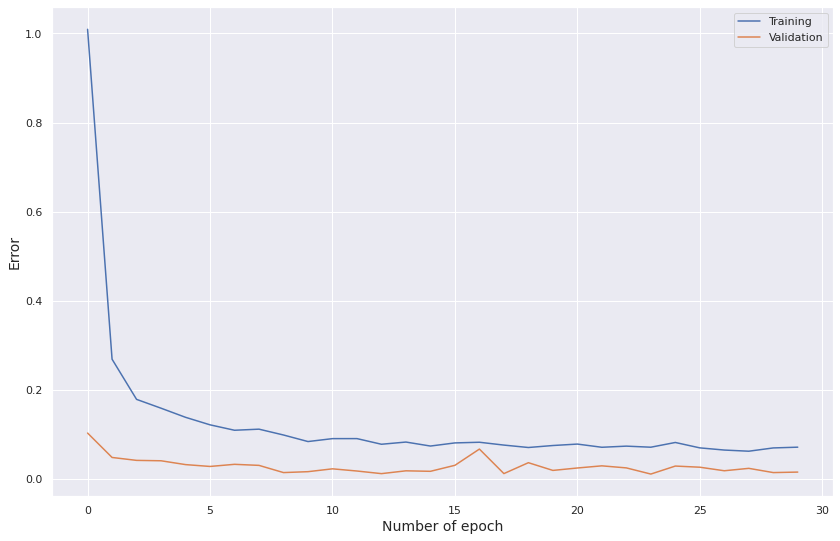

In [18]:
# accessing history
archieve = model

model_loss = pd.DataFrame( model.history.history )
# model_loss = pd.DataFrame( model.history )

# plotting the history
sns.set_theme(style="darkgrid")
model_loss.columns = ['Training', 'accuracy', 'Validation', 'val_accuracy']
model_loss[['Training', 'Validation']].plot(figsize=(14,9))

# defining the label names for X-axis and Y-axis
plt.xlabel("Number of epoch", fontsize=14)
plt.ylabel("Error", fontsize=14)

# saving the plot
dpi = 1200
image_name = 'lossCurve'
image_save_path = f'{rootDir}03. Generated Data/Plots/{image_name}'
plt.savefig(image_save_path, dpi=dpi, pad_inches=0.2, bbox_inches='tight')

<br>

## 8.2. Classification Report and Confusion Matrix

<br>

### Preparing Data

In [19]:
# copying the original X and y test data
X_test_new = test_X
y_test_new = test_y

In [20]:
def fill_missing_class() :
  '''
    This function will fill any Intent-Class missing in 'y_test'.
    The sklearn Train_Test_Split generates Train and Test data randomly. So any classes can be missed in the test data.
  '''

  # accessing the global numpy array to write
  global X_test_new
  global y_test_new

  # finding the classes in train and test data
  yTrainArgmax = set( train_y.argmax(axis=1) )
  yTestArgmax  = set( test_y.argmax(axis=1) )

  # finding the intent classes missing in 'y_test' by comparing with 'y_train'
  missing_classes = yTrainArgmax.difference(yTestArgmax)
  
  # convering to List
  missing_classes = list(missing_classes)

  # iterating the missing classes 
  for mc in missing_classes:

    # finding the missing classes that exist in 'y_train'
    indices_mc = np.where(train_y.argmax(axis=1) == mc)[0]  # indices of any missing class

    # if any missing class has more then 5 entity then take first 5 otherwise take whatever entity the class has
    if len(indices_mc) > 4 :
      indices_mc = indices_mc[:5]

    # iteraring the indices, and appending intents from 'X_train' and 'y_train' using the indices
    for i in indices_mc:
      X_test_new = np.append(X_test_new, [train_X[i]], axis=0)
      y_test_new = np.append(y_test_new, [train_y[i]], axis=0)


In [21]:
# filling any intents missing in 'y_test'
fill_missing_class()

<br>

### Predicting on 'y_test' data

In [22]:
# prediction on test set
predictions = model.predict(X_test_new)

16/16 [==============================] - 4s 198ms/step


In [23]:
# finding the actual classes
y_test_argmax = y_test_new.argmax(axis=1)

# finding the predicted classes
predictions_argmax = predictions.argmax(axis=1)

<br>

### 8.2.3. Classification Report

In [24]:
# importing the library
from sklearn.metrics import classification_report

# classification report
_CR = classification_report(y_test_argmax, predictions_argmax, target_names=digit_class_name)

# printing the report
print( _CR )

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.98      1.00      0.99        44
           2       1.00      1.00      1.00        46
           3       1.00      1.00      1.00        63
           4       1.00      1.00      1.00        47
           5       1.00      1.00      1.00        54
           6       0.98      1.00      0.99        44
           7       1.00      0.98      0.99        55
           8       1.00      1.00      1.00        48
           9       1.00      1.00      1.00        53

    accuracy                           1.00       508
   macro avg       1.00      1.00      1.00       508
weighted avg       1.00      1.00      1.00       508



<br>

### 8.2.4. Confusion Matrix

In [25]:
# importing the library
from sklearn.metrics import confusion_matrix

# calculationg confusion matrix
confusionMat = confusion_matrix(y_test_argmax, predictions_argmax)

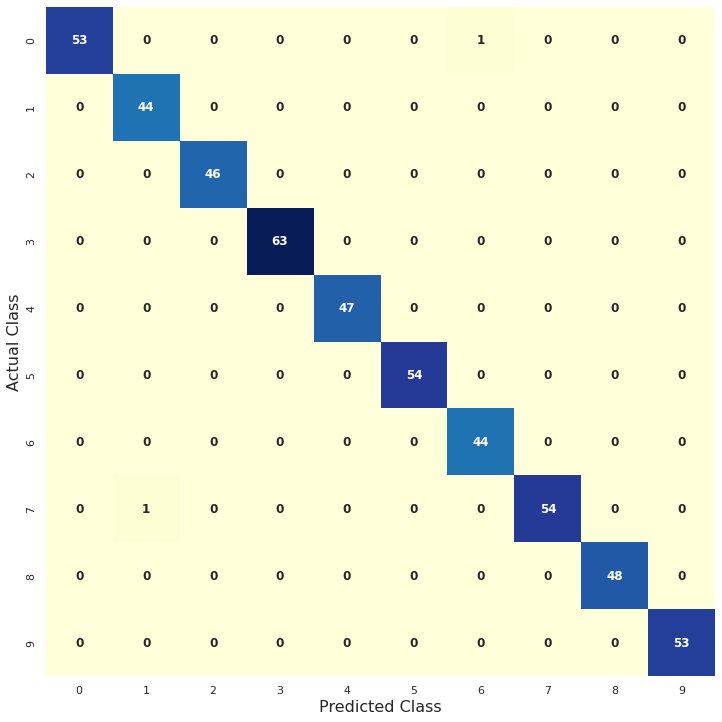

In [26]:
# defining figure size
plt.figure(figsize=(12,15))

# plotting heatmap of confusion matrix
sns.heatmap(confusionMat, square=True, fmt='d', 
            cbar=False, cmap='YlGnBu',  
            xticklabels=digit_class_name,
            yticklabels=digit_class_name,
            annot=True,
            annot_kws={
                "fontsize":12,
                'fontweight': 'bold',
                },
          )

# defining the label names for X-axis and Y-axis
plt.xlabel('Predicted Class', fontsize=16)
plt.ylabel('Actual Class', fontsize=16)

# saving the plot
dpi = 1200
image_name = 'ConfusionMatrix'
image_save_path = f'{rootDir}/03. Generated Data/Plots/{image_name}'
plt.savefig(image_save_path, dpi=dpi, pad_inches=0.2, bbox_inches='tight')

<br>

## 8.3. Prediction on New Data

Creating Data

In [27]:
# accessing the main data set
_data = data_X
_target = data_y

# defining random position
pos = random.randint(0, len(_data))

# collecting data from main dataset
new_data = _data[pos]

# preprocessing the new data and converting the target to categorical
new_data = preprocess(new_data)
_target = to_categorical(_target, number_of_classes)


# reshaping the data
new_data = new_data.reshape(-1, 32, 32, 1)

# extracting true result
true_result_list = _target[pos]
true_class  = int( np.argmax(true_result_list) )


Predicting Class for Created Data

In [28]:
# predicting result for new_data
predicted_class = model.predict(new_data)

# extracting the maximum predicted calss
predicted_class = int( np.argmax(predicted_class, axis=1) )

1/1 [==============================] - 0s 32ms/step


Extracting Class name

In [29]:
# extracting predicted class name
predicted_class_name = digit_class_name[predicted_class]
print(f"\n The predicted class is : '{predicted_class_name}'")

# extracting actual class name
true_class_name = digit_class_name[true_class]
print(f"\n The actual class is : '{true_class_name}'")


 The predicted class is : '2'

 The actual class is : '2'


<br>

<a name='9-save-model'></a>

# 9. Save Model

In [30]:
# defining the name of the model
modelName = 'DigitClassifier1.h5'

# creating the path
path = rootDir + '03. Generated Data/' + modelName

# save model
model.save( path )